# Find Alpha with moment balence  

## Imports

In [1]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import aerosandbox as asb
import aerosandbox.numpy as np
from Create_airplane import import_from_xflr5_with_airfoils

## Functions 

Geometry

In [2]:
def findVec(point1, point2):
    # setting unitSphere to True will make the vector scaled down to a sphere with a radius one, instead of it's orginal length
    finalVector = [0 for coOrd in point1]
    for dimension, coOrd in enumerate(point1):
        # finding total differnce for that co-ordinate(x,y,z...)
        deltaCoOrd = point2[dimension] - coOrd
        # adding total difference
        finalVector[dimension] = deltaCoOrd

    else:
        return finalVector


def cross_prod(a, b):
    result = [
        a[1] * b[2] - a[2] * b[1],
        a[2] * b[0] - a[0] * b[2],
        a[0] * b[1] - a[1] * b[0],
    ]

    return result

Modify the airplane

In [3]:
def Modify_twist_airplane(airplane: asb.Airplane, twists: list) -> None:
    try : 
        for i in range(len(airplane.wings[0].xsecs)):
            airplane.wings[0].xsecs[i].twist = twists[i]
    except Exception as e:
            print(f" !!!!! FAILED MODIFY TWIST: {airplane.name}: twist{twists} ")
            print(e)

Change the camber

In [4]:
def change_camber_airfoil(airfoil : asb.Airfoil, delta_camber : float):

    # Select N coordinates on the upper/lower surfaces
    N = 151
    x_over_c = np.cosspace(0, 1, N)
    upper = airfoil.upper_coordinates()[::-1]
    lower = airfoil.lower_coordinates()

    upper_interpolated = np.interp(
        x_over_c,
        upper[:, 0],
        upper[:, 1],
        )
    lower_interpolated = np.interp(
            x_over_c,
            lower[:, 0],
            lower[:, 1],
        )

    # Get local/max/new Camber 
    initial_local_camber = airfoil.local_camber(x_over_c = x_over_c)
    initial_max_camber = airfoil.max_camber(x_over_c_sample=x_over_c)
    ratio = (initial_max_camber + delta_camber)/initial_max_camber 
    new_local_camber = initial_local_camber * ratio

    # Calculate the new coordinates
    # ( Y(+)new+Y(-)new )/ 2 = new_local_camber -> Camber definition
    # Y(+)new - Y(-)new = Y(+) - Y(-) -> Same local thickness
    new_upper = np.flipud(np.array([ # Need to flip the upper surface coordinates
        [
            x_over_c[i],
            new_local_camber[i] + 1/2 * (upper_interpolated[i] - lower_interpolated[i])
        ] for i in range(N)
    ]))

    new_lower = np.array([
        [
            x_over_c[i],
            new_local_camber[i] - 1/2 * (upper_interpolated[i] - lower_interpolated[i])
        ] for i in range(1,N)
    ])

    # return the new airfoil
    return asb.Airfoil(coordinates = np.concatenate([new_upper, new_lower]), name="test_camber")


def change_camber_airplane(airplane : asb.Airplane, delta_camber : float):
    
    new_airplane = airplane.deepcopy()
    for xsec in new_airplane.wings[0].xsecs : 
        xsec.airfoil = change_camber_airfoil(xsec.airfoil, delta_camber)

    return new_airplane

## Create the model

In [5]:
# %% Import airplane from Xflr5
foldername = "R1V521mMK13"

folder_to_load = os.path.join(os.getcwd(), "xflr5_file", foldername)
bar_tab_to_load = os.path.join(os.getcwd(), "xflr5_file", foldername, "tabs_R1V521mMK13.xlsx")
lines_tab_to_load = os.path.join(os.getcwd(), "xflr5_file", foldername, "Lines_data.xlsx")


In [6]:
# %%  Load Airplane
airplane_xflr5 = import_from_xflr5_with_airfoils(
    folder_to_load,
    force_midle=True,
    derotate=False,
    draw_three_view=False,  # filename, draw 3d view (True/False)
)
airplane_xflr5_origin = airplane_xflr5.deepcopy()

# %% Load bar data
df_bar_tab = pd.read_excel(bar_tab_to_load)
df_bar_tab.interpolate(limit_direction="both", inplace=True)
tab_to_consider = ["A", "B"]
distance_tab_pct = df_bar_tab[tab_to_consider].diff(axis=1)[tab_to_consider[-1]]
distance_tab_mm = (distance_tab_pct / 100) * df_bar_tab["chord"]

# %% Load lines data
df_lines_tab = pd.read_excel(lines_tab_to_load)
df_lines_tab.interpolate(limit_direction="both", inplace=True)


Rib 0 and 1 will be force to 0 diedral


C:\Users\RomainLambert\AppData\Local\Temp\ipykernel_14624\1577747182.py:19: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_lines_tab.interpolate(limit_direction="both", inplace=True)


## Parameters

In [7]:
# %% Geometry
cg_y = 0.
line_length = 25.0 # [m] length of the lines
middle_chord = airplane_xflr5.wings[0].xsecs[0].chord # The middle airfoil
pos_b = 0.63*middle_chord # [%] B position along the chord
pos_a = 0.07*middle_chord # [%] A position along the chord

# %% Variables
min_cg_x = -2.0 # [m]
max_cg_x = 2.0 # [m]
init_cg_x = pos_a # [m]
min_bar = 0. # [mm]
max_bar = 400  # [mm]
init_bar = 0. # [mm]

# %% Line drag coefs
total_line_surface = np.sum(df_lines_tab["Number"]*df_lines_tab["Sewn"]/1000*df_lines_tab["Diameter"]/1000)
Cx_line = 1.0
line_drag_aera_SCx = Cx_line * total_line_surface
# line_drag_aera_SCx = 0.1849
# profile_drag_coef_Cx0 = 0.012 + 0.001
# CD_profile = 1.328 * Re**-0.5

atmo = asb.Atmosphere(altitude=0)

# %% Vlm
chordwise_resolution = 8

# %% Airplane
aerodynamic_center = airplane_xflr5.aerodynamic_center()
load = 1500 # [N] masse*g

## Optimize

In [8]:
list_polar = []
list_failed = []

for delta_camber in np.arange(0.00, 0.001, 0.001) :
    # %% Change the airplane camber
    airplane_xflr5 = change_camber_airplane(airplane_xflr5_origin, delta_camber)
    
    for velocity in np.arange(14, 15, 1) :
        # %% Usefull parameters
        dynamic_pressure = 0.5 * atmo.density() * velocity**2

        Re = (
                atmo.density()
                * velocity
                * airplane_xflr5.wings[0].mean_aerodynamic_chord()
                / atmo.dynamic_viscosity()
            )

        opti = asb.Opti()

        # %% Variables
        var_cg_x = opti.variable(init_guess=init_cg_x, lower_bound=min_cg_x, upper_bound=max_cg_x) # [m] <cg|x> position
        var_bar = opti.variable(init_guess=init_bar, lower_bound=min_bar, upper_bound=max_bar) # [mm] Bar position

        # %% Calculate cg_z depending on cg_x
        cg_z = -np.sqrt((line_length**2-(var_cg_x-pos_a)**2))

        # %% Calculate alpha depending on cg_x and the bar position
        bar_travel = [element * var_bar for element in df_bar_tab["system"]] # [mm]
        alpha_bar = np.degrees(
            np.arctan(np.array(bar_travel)/ np.array(distance_tab_mm))
        )  + df_bar_tab["angle"] # [deg]

        alpha = np.degrees(np.arctan((var_cg_x-pos_a)/cg_z)) # [deg]

        # %% Config the airplane
        Modify_twist_airplane(airplane_xflr5, alpha_bar)
        airplane_xflr5.cg = [var_cg_x, cg_y, cg_z ]
        airplane_xflr5.line_drag_pt = [var_cg_x/2, cg_y/2, cg_z/2]

        print(f" \n ---\n>>computing  velocity= {velocity} delta_camber:{delta_camber}")
        

        # %% Simulate
        vlm = asb.VortexLatticeMethod(
            chordwise_resolution=chordwise_resolution,
            spanwise_resolution=1,
            spanwise_spacing_function=np.linspace,
            airplane=airplane_xflr5,
            op_point=asb.OperatingPoint(
                velocity=velocity,  # m/s
                alpha=alpha,  # degree
            ),
        )

        vlm_result = vlm.run()

        ###########################################################################
        ################################# Moments #################################
        ###########################################################################

        # %% Aerodynamic moment
        norm_fb = np.sqrt(vlm_result["F_g"][0] ** 2 + vlm_result["F_g"][2] ** 2) # [N] Norm of the aerodynamic force
        angle_fb_geom = np.arctan(np.abs(vlm_result["F_g"][2]/vlm_result["F_g"][0])) # [rad] Angle between the geometry and the aerodynamic force
        distance_application_point_aero = -vlm_result["M_g"][1] / (norm_fb*np.sin(angle_fb_geom)) 
        application_point_aero = [
            distance_application_point_aero * np.cos(np.radians(alpha_bar[0])),
            0,
            -distance_application_point_aero * np.sin(np.radians(alpha_bar[0])),
        ] # [m] Application point from the origin of the geometry axes. We suppose M_g calculated at the origin of the geometry axes

        vector_force_aero = findVec(airplane_xflr5.cg, application_point_aero) # [m] Application point from the CG in the geometry axes

        moment_vector_aero = cross_prod(vector_force_aero, vlm_result["F_g"]) # [Nm] Aerodynamic moment calculated from the CG in the geometry axes
        moment_aero = moment_vector_aero[1]

        # %% profile drag
        middle_foil = airplane_xflr5.wings[0].xsecs[0].airfoil.to_kulfan_airfoil() # The middle airfoil
        xfoil_simulation = middle_foil.get_aero_from_neuralfoil(
            alpha=alpha + alpha_bar[0], # [deg] local angle of the middle airfoil
            Re=Re,
            mach=0,
        )

        profile_drag_coef_Cd = xfoil_simulation['CD'][0]
        profile_drag_coef_Cl = xfoil_simulation['CL'][0]
        profile_drag_coef_Cm = xfoil_simulation['CM'][0]
        profile_drag_angle = np.degrees(np.arctan(profile_drag_coef_Cl/profile_drag_coef_Cd)) + alpha + alpha_bar[0] # [deg] Angle between the lift/drag force and the the chord
        profile_drag_chord = airplane_xflr5.wings[0].xsecs[0].chord

        distance_point_profil_drag = (
            profile_drag_coef_Cm * profile_drag_chord/(np.sqrt(profile_drag_coef_Cd**2+profile_drag_coef_Cl**2)*np.sin(np.radians(profile_drag_angle)))
            # + 0.25 * profile_drag_chord
        ) # distance between the application point and the leading edge

        application_point_profil_drag = [
            distance_point_profil_drag * np.cos(np.radians(alpha_bar[0])),
            0,
            -distance_point_profil_drag * np.sin(np.radians(alpha_bar[0]))
        ] # Application point from the origin in geometry axes

        drag_profile = (
            dynamic_pressure * profile_drag_coef_Cd * airplane_xflr5.wings[0].area()
        ) # [N]

        vector_drag_profile = [
            drag_profile * np.cos(np.radians(alpha)),
            0,
            drag_profile * np.sin(np.radians(alpha)),
        ] # [N] in geometry axes

        vector_force_drag_profile = findVec(
            airplane_xflr5.cg, application_point_profil_drag
        ) # Application point from cg in geometry axes

        moment_vector_drag_profile = cross_prod(
            vector_force_drag_profile, vector_drag_profile
        ) # [N]

        moment_drag_profile = moment_vector_drag_profile[1]

        # %% line drag

        drag_line = dynamic_pressure * line_drag_aera_SCx # [N]
        vector_drag_line = [
            drag_line * np.cos(np.radians(alpha)),
            0,
            drag_line * np.sin(np.radians(alpha)),
        ]
        vector_force_drag_line = findVec(airplane_xflr5.cg, airplane_xflr5.line_drag_pt) # Application point from cg in geometry axes
        moment_vector_drag_line = cross_prod(vector_force_drag_line, vector_drag_line)
        moment_drag_line = moment_vector_drag_line[1]

        ##
        moment = (
            moment_aero + moment_drag_line + moment_drag_profile
        )

        moment2 = moment * moment
        ##

        # %% Subject to
        opti.subject_to(
            [
                np.linalg.norm(vlm_result["F_g"]) * np.sin(angle_fb_geom) == load,  # impose Load
                vlm_result["F_g"][2] > 0,  # impose direction
            ]
        )

        L_over_D = vlm_result["CL"] / vlm_result["CD"]

        # %% Criteria
        opti.minimize(moment2)

        # %% Solve
        sol = opti.solve(max_iter=100)

        # %% Results
        find_alpha = sol.value(alpha) # [deg]
        find_alpha_bar = sol.value(alpha_bar[0]) # [deg]
        find_angle_fb_geom = sol.value(angle_fb_geom) # [rad]

        find_var_bar = sol.value(var_bar) # [m]
        find_cg_x = sol.value(var_cg_x) # [m]
        find_application_point_aero = sol.value(application_point_aero) # [m]
        find_application_point_profil_drag = sol.value(application_point_profil_drag) # [m]

        find_drag_profile = sol.value(drag_profile) # [N]

        find_vector_drag_profile = sol.value(vector_drag_profile) # [m]
        find_vector_drag_line = sol.value(vector_drag_line) # [m]

        find_moment = sol.value(moment) # [Nm]
        find_moment_drag_profile = sol.value(moment_drag_profile) # [Nm]
        find_moment_drag_line = sol.value(moment_drag_line) # [Nm]

        print(f" \n ---\n>>End computing  velocity= {velocity} delta_camber:{delta_camber}")
        print(f"Speed : {velocity:.3f} m/s ")
        print(f"moment : {find_moment:.3f} Nm ")

        vlm.substitute_solution(sol)
        vlm_opt = vlm.run()
        data = {
            "c": chordwise_resolution,
            "delta_camber": delta_camber,
            "pos_a": pos_a,
            "pos_b": pos_b,
            "cg_x": find_cg_x,
            "alpha_bar": find_alpha_bar,
            "angle_fb_geom": find_angle_fb_geom,
            "bar": find_var_bar,
            "alpha": find_alpha,
            "moment": find_moment,
            "drag_profile": find_drag_profile,
            "find_application_point_aero": find_application_point_aero,
            "application_point_profil_drag": find_application_point_profil_drag,
            "find_vector_drag_profile": find_vector_drag_profile,
            "find_vector_drag_line": find_vector_drag_line,
            "find_moment_drag_profile": find_moment_drag_profile,
            "find_moment_drag_line": find_moment_drag_line,
            "speed": velocity,
            "force": np.linalg.norm(vlm_opt["F_g"]),
            "r": vlm_opt,
        }
        list_polar.append(data)

print("________")

print("end")

print(f" nb fails : {len(list_failed)}")

 
 ---
>>computing  velocity= 14 delta_camber:0.0
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        5
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.2931752e+05 1.35e+0

## Analysis

In [9]:
# %% Export data 
df = pd.json_normalize(list_polar)

df["glide"] = df["r.CL"] / df["r.CD"]
df["alpha_tot"] = df["alpha"] + df["alpha_bar"]
df.to_excel("polar_c_alphafind_cg.xlsx")
print("OK exported")

OK exported


Draw

In [13]:
import plotly.graph_objects as go

scale_lift = 0.005
scale_drag = 0.5
fig = vlm.draw(draw_streamlines=False, backend="plotly", show=False)

# %% 3D Lift/Drag force
fig.add_trace(
    go.Scatter3d(
        x=[
            find_application_point_aero[0],
            find_application_point_aero[0] + vlm_opt["F_g"][0] * scale_lift,
        ],
        y=[
            find_application_point_aero[1],
            find_application_point_aero[1] + vlm_opt["F_g"][1] * scale_lift,
        ],
        z=[
            find_application_point_aero[2],
            find_application_point_aero[2] + vlm_opt["F_g"][2] * scale_lift,
        ],
        mode="lines",
        name="3D Lift/Drag force",
    )
)

# %% 2D profil drag force
fig.add_trace(
    go.Scatter3d(
        x=[
            aerodynamic_center[0],
            aerodynamic_center[0] + find_vector_drag_profile[0] * scale_drag,
        ],
        y=[
            aerodynamic_center[1],
            aerodynamic_center[1] + find_vector_drag_profile[1] * scale_drag,
        ],
        z=[
            aerodynamic_center[2],
            aerodynamic_center[2] + find_vector_drag_profile[2] * scale_drag,
        ],
        mode="lines",
        name="profile_drag",
    )
)

# %% Line drag force
fig.add_trace(
    go.Scatter3d(
        x=[
            airplane_xflr5.line_drag_pt[0],
            airplane_xflr5.line_drag_pt[0] + find_vector_drag_line[0] * scale_drag,
        ],
        y=[
            airplane_xflr5.line_drag_pt[1],
            airplane_xflr5.line_drag_pt[1] + find_vector_drag_line[1] * scale_drag,
        ],
        z=[
            airplane_xflr5.line_drag_pt[2],
            airplane_xflr5.line_drag_pt[2] + find_vector_drag_line[2] * scale_drag,
        ],
        mode="lines",
        name="line_drag",
    )
)

# %% Airplane
fig.add_trace(
    go.Scatter3d(
        x=[airplane_xflr5.cg[0]],
        y=[airplane_xflr5.cg[1]],
        z=[airplane_xflr5.cg[2]],
        mode="markers",
        marker=dict(
            size=6,
        ),
    )
)

fig.show()

Plot

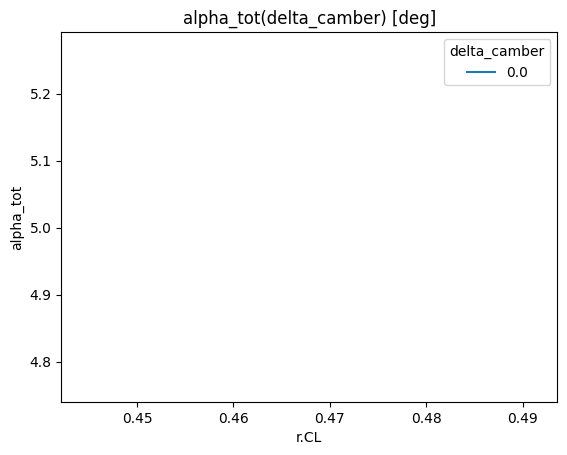

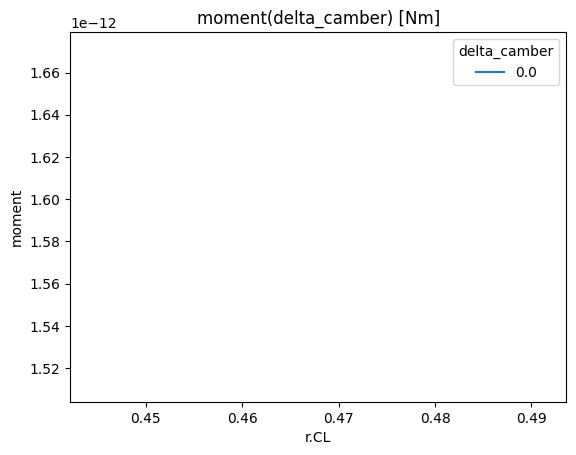

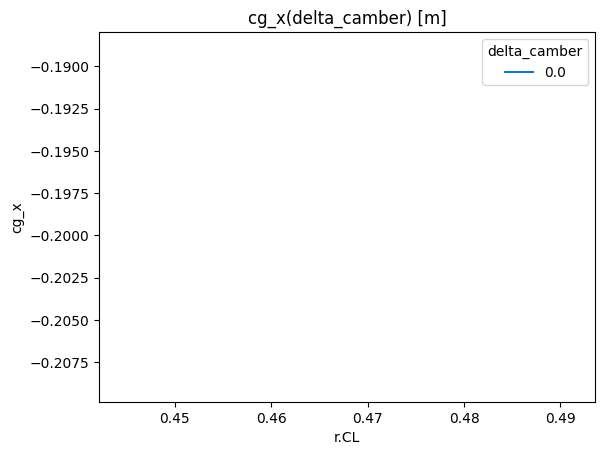

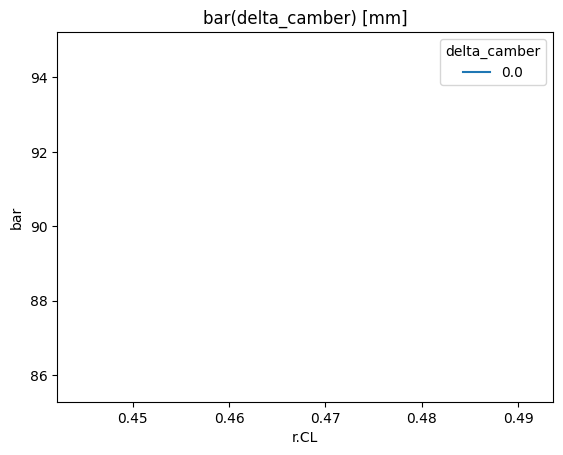

In [11]:
# %% Alpha
ax_alpha_tot = sns.lineplot(data=df, x="r.CL", y="alpha_tot", hue="delta_camber")
ax_alpha_tot.set_title("alpha_tot(delta_camber) [deg]")
plt.show()

# %% Moment
ax_moment = sns.lineplot(data=df, x="r.CL", y="moment", hue="delta_camber")
ax_moment.set_title("moment(delta_camber) [Nm]")
plt.show()

# %% Cg_x
ax_cg_x = sns.lineplot(data=df, x="r.CL", y="cg_x", hue="delta_camber")
ax_cg_x.set_title("cg_x(delta_camber) [m]")
plt.show()

# %% Bar
ax_bar = sns.lineplot(data=df, x="r.CL", y="bar", hue="delta_camber")
ax_bar.set_title("bar(delta_camber) [mm]")
plt.show()

A = np.vstack([df["alpha"], np.ones(len(df["alpha"]))]).T
r_linear = np.linalg.lstsq(A, df["r.CL"], rcond=None)
Coeff_cl = r_linear[0]

# Stability

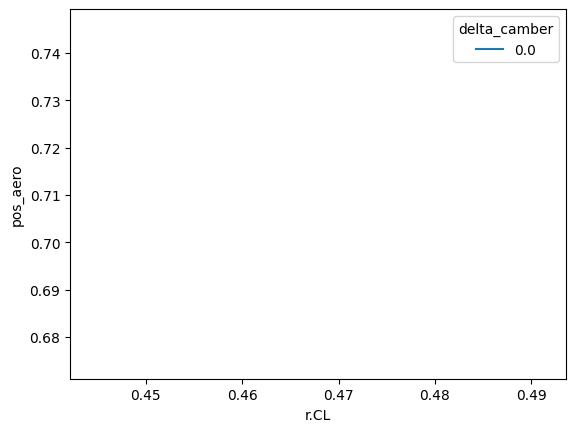

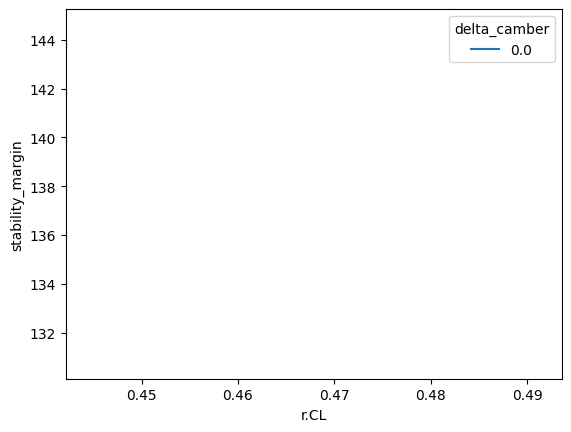

In [12]:
df["normal_force_aero"] = df["force"] * np.sin(df["angle_fb_geom"])
df["pos_aero"] = [np.linalg.norm(x) for x in df["find_application_point_aero"]]

df["tension_B"] = (df["pos_aero"]-df["pos_a"]) / (df["pos_b"]-df["pos_a"]) * df["normal_force_aero"]
df["tension_A"] = (df["pos_b"] - df["pos_aero"]) / (df["pos_b"]-df["pos_a"]) * df["normal_force_aero"]
df["stability_margin"] = df["tension_A"] - df["tension_B"]

# %% Plot
# %% Pos aero
ax_stability = sns.lineplot(data=df, x="r.CL", y="pos_aero", hue="delta_camber")
ax_alpha_tot.set_title("pos_aero (Cl)")
plt.show()

# %% Stability margin
ax_stability = sns.lineplot(data=df, x="r.CL", y="stability_margin", hue="delta_camber")
ax_alpha_tot.set_title("stability (delta_camber)")
plt.show()